<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Mounted at /gdrive


In [2]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
df = pd.read_csv("data/df_imputed_week_shift.csv", index_col = 0, parse_dates = True)

In [0]:
cols = ["speed", "flow", "speed_-2", "speed_-1","speed_+1", "speed_+2", "flow_-2", "flow_-1", "flow_+1", "flow_+2", "speed_limit"]
speed_cols = ["speed", "speed_-2", "speed_-1","speed_+1", "speed_+2"]
flow_cols = ["flow", "flow_-2", "flow_-1", "flow_+1", "flow_+2"]

### First resample to elmininate some noise

In [0]:
import numpy as np
def resample_df(df, freq = "10T", method_speed = np.mean, method_flow = np.sum):
    copied = df.copy()
    copied = copied.resample(freq).agg({
           "speed": method_speed, "speed_-2": method_speed, "speed_-1": method_speed, "speed_+1": method_speed, "speed_+2": method_speed,
           "flow": method_flow, "flow_-2": method_flow, "flow_-1": method_flow, "flow_+1": method_flow, "flow_+2": method_flow,
           "speed_limit": np.median})
    return copied

In [0]:
r_df = resample_df(df, freq = "H")

### Train test split. The final year is reserved for testing. (Val will be relevant later?)

In [0]:
def train_val_test_split(df, val_year, test_year):
    # train, test
    return df[(df.index.year != val_year) & (df.index.year != test_year)].copy(), df[df.index.year == val_year].copy(), df[df.index.year == test_year].copy()

In [0]:
train, val, test = train_val_test_split(r_df, 2018, 2019)

In [0]:
import numpy as np
def log_transform(df):
    copy = df.copy()
    return np.log(copy.iloc[:, :-1].replace(0, 1e-15)).join(df.iloc[:, -1], how = 'inner')

# Log transform. First set 0s to very low value 'cause you can't log 0.
train_log = log_transform(train)
val_log = log_transform(val)

In [0]:
def calc_mean(df, col):
    # mean(100), mean(120)
    return df.groupby(['speed_limit'])[col].mean().values

def calc_sd(df, col):
    # sd(100), sd(120)
    return df.groupby(['speed_limit'])[col].std().values

def normalize_df(df, cols):
    copy = df.copy()
    for col in cols:
        # Find mean and sd for column
        mean100, mean120 = calc_mean(copy, col)
        sd100, sd120 = calc_sd(copy, col)
        copy[col] = np.where(copy.speed_limit == 100, (copy[col] - mean100) / sd100, (copy[col] - mean120) / sd120)
    return copy

In [0]:
train_norm = normalize_df(train_log, cols[:-1])
val_norm = normalize_df(val_log, cols[:-1])

In [0]:
train2 = train.speed.values
train2 = train2.reshape(-1, 1)

val2 = val.speed.values
val2 = val2.reshape(-1, 1)

test2 = test.speed.values
test2 = test2.reshape(-1, 1)

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train2)

train.loc[:, 'speed'] = scaler.transform(train2)
val.loc[:, 'speed'] = scaler.transform(val2)

test_data = test.iloc[:, 0].values
test_data = np.reshape(test_data, (-1, 1))
test_data = scaler.transform(test2)

In [0]:
# Generates sequential 3D batches to feed to the model
def generator(data, lookback, delay, min_index = 0, max_index = None, 
              shuffle = False, batch_size = 128, step = 1, target_col = 0):
    # If max index not given, subtract prediction horizon - 1 (len to index) from last data point
    if max_index is None:
        max_index = len(data) - delay - 1
    # Set i to first idx with valid lookback length behind it
    i = min_index + lookback
    while 1:
        # Use shuffle for non-sequential data
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size = batch_size)
        # Else for sequential (time series)
        else:
            # Check if adding batch exceeds index bounds
            if i + batch_size >= max_index:
                # Return i to beginning
                i = min_index + lookback
            # Select next valid row range
            rows = np.arange(i, min(i + batch_size, max_index))
            # Increment i
            i += len(rows)
        # Initialize sample and target arrays
        samples = np.zeros((len(rows),
                            lookback // step,
                            np.shape(data)[-1]))
        targets = np.zeros((len(rows),))
        # Generate samples, targets
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_col]
        yield samples, targets

In [0]:
lookback = 24
delay = 1

In [0]:
# Generator 'settings'

train_data = train.iloc[:, 0].values
train_data = np.reshape(train_data, (-1, 1))


step = 1
batch_size = 128
min_index_train = 0
max_index_train = len(train_data)
train_gen = generator(train_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = min_index_train,
                      max_index = max_index_train,
                      step = step, 
                      batch_size = batch_size,
                      target_col = 0)


val_data = val.iloc[:, 0].values
val_data = np.reshape(val_data, (-1, 1))

min_index_val = 0
max_index_val = len(val_data)
val_gen = generator(val_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = min_index_val,
                      max_index = max_index_val,
                      step = step, 
                      batch_size = batch_size,
                      target_col = 0)


min_index_test = 0
max_index_test = len(test_data)
test_gen = generator(test_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = min_index_test,
                      max_index = max_index_test,
                      step = step, 
                      batch_size = batch_size,
                      target_col = 0)


In [14]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0-rc1'

In [0]:
# ML
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [0]:
# Train Stacked LSTM with Dropout
model = Sequential()
model.add(layers.Conv1D(filters = 32, kernel_size = (1), activation = 'relu', input_shape = (lookback, 1)))
model.add(layers.LSTM(32,
                      dropout = 0.1,
                      recurrent_dropout = 0.5,
                      input_shape = (lookback, 32)))
model.add(layers.Dense(1))

In [0]:
model.compile(optimizer = RMSprop(learning_rate = 0.001), loss = 'mae', metrics = ['mae', 'mse'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 32)            64        
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 8,417
Trainable params: 8,417
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(train_gen,
                    steps_per_epoch = (((max_index_train + 1) // batch_size) + 1),
                    validation_data = val_gen, validation_steps = (((max_index_val + 1) // batch_size) + 1),
                    epochs = 20)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 480 steps, validate for 69 steps
Epoch 1/20
480/480 [==============================] - 22s 46ms/step - loss: 0.0574 - mae: 0.0574 - mse: 0.0094 - val_loss: 0.0571 - val_mae: 0.0571 - val_mse: 0.0069
Epoch 2/20
480/480 [==============================] - 19s 40ms/step - loss: 0.0408 - mae: 0.0408 - mse: 0.0049 - val_loss: 0.0577 - val_mae: 0.0577 - val_mse: 0.0067
Epoch 3/20
480/480 [==============================] - 19s 39ms/step - loss: 0.0388 - mae: 0.0388 - mse: 0.0047 - val_loss: 0.0590 - val_mae: 0.0590 - val_mse: 0.0062
Epoch 4/20
480/480 [==============================] - 19s 39ms/step - loss: 0.0371 - mae: 0.0371 - mse: 0.0044 - val_loss: 0.0537 - val_mae: 0.0537 - val_mse: 0.0056
Epoch 5/20
480/480 [==============================] - 19s 39ms/step - loss: 0.0348 - mae: 0.0348 - mse: 0.0040 - val_loss: 0.0448 - val_mae: 0.0448 - val_mse: 0.0050
Epoch 6/20
480/480 [==============================] - 19s 39ms/step - loss: 0

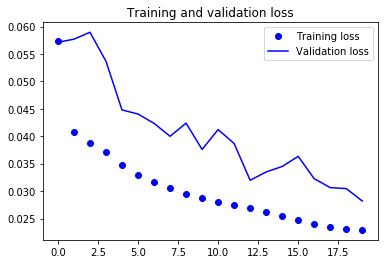

In [20]:
import matplotlib.pyplot as plt

#PLOT
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
preds = pd.DataFrame(data = test['speed'].values, index = test.index, columns = ['True'])


In [0]:
Prediction = model.predict(test_gen, steps = (((max_index_test + 1) // batch_size) + 1))

In [0]:
what = scaler.inverse_transform(Prediction)

In [0]:
what = what[:8712]

In [0]:
preds['Prediction'] = what
preds['Prediction'] = preds['Prediction'].shift(10)

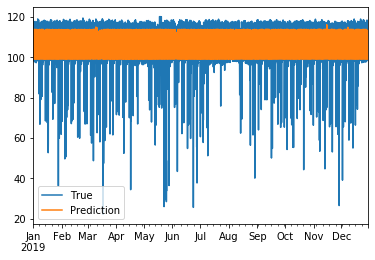

In [44]:
#PLOT
preds.plot()

In [45]:
preds.describe()

,True,Prediction
count,8712.000000,8702.000000
mean,102.937465,104.151741
std,10.748936,5.751995
min,22.254722,98.989693
25%,97.910625,99.393486
50%,99.273889,100.403145
75%,113.051944,110.907471
max,120.000000,115.989548
